# WQU Capstone project - Short-term trading strategy on G10 currencies
## Notebook six - Machine Learning - level 1 modells

* Sergey Chigrinov - chigrinov.s.88@gmail.com
* Dhruv Agrawal -  dhruva1@stanfordalumni.org
* Man Sing Ho - mshoalbert@gmail.com

### Jun-Aug-2020

In this notebook we build a framework to choose the best performing algorythms later. 

In [1]:
import sys
import os
#insert you own path or use relative path
path_to_project = os.path.realpath('..') # r'C:\WQU\Capstone\Working_files'
sys.path.append(path_to_project)

In [2]:
from WQUcapstoneCode.ml.ml import cv_with_custom_score

In [3]:
import pandas as pd
import numpy as np
import datetime as dt
from tqdm import tqdm
from multiprocessing import cpu_count
import warnings
warnings.filterwarnings('ignore')

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-talk')
plt.style.use('bmh')

In [5]:
from sklearn.metrics import *
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
#from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
#from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.calibration import calibration_curve
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [6]:
ticker = 'AUD/USD'

In [7]:
preprocessed_path= os.path.join(path_to_project, 'preprocessed_data', ''.join(ticker.split('/')) + '_feat.csv')
data = pd.read_csv(preprocessed_path, index_col=0, parse_dates=True)
#data.index = [dt.datetime.strptime(date, '%Y-%m-%d %H:%M:%S') for date in data.index]

We need to split the data into training, validation and test sets. We may try using "purged k-fold cross validation", as in the book, however, our data is already not dense, so we may use just a regular cross validation to choose best modells.

In [8]:
all_feature_cols = data.columns[:-2]
frdif_feature_dict = {c[:-6]:c for c in all_feature_cols if c[-5:]=='frdif'}
ex_frdiff_cols = [c for c in all_feature_cols if c not in frdif_feature_dict.values()]
frdiff_cols = [c for c in all_feature_cols if c not in frdif_feature_dict.keys()]
side_cols = [c for c in all_feature_cols if c[-4:]=='side']

In [9]:
# split the data into 3 parts: ~50%, 25%, 25%
n = len(data)
train_ids, valid_ids, test_ids = (0, int(np.floor(n/2))), (int(np.ceil(n/2)), int(np.floor(n/2+n/4))), (int(np.ceil(n/2+n/4)), n)
train_ids, valid_ids, test_ids 

((0, 476), (476, 714), (714, 952))

In [10]:
X_train = data[all_feature_cols].iloc[train_ids[0]:train_ids[1],:]
X_valid = data[all_feature_cols].iloc[valid_ids[0]:valid_ids[1],:]
X_test = data[all_feature_cols].iloc[test_ids[0]:test_ids[1],:]

Y_train = data.bin.iloc[train_ids[0]:train_ids[1]]
Y_valid = data.bin.iloc[valid_ids[0]:valid_ids[1]]
Y_test = data.bin.iloc[test_ids[0]:test_ids[1]]

target_rtns_train, target_rtns_valid, target_rtns_test = data.ret.iloc[train_ids[0]:train_ids[1]], data.ret.iloc[valid_ids[0]:valid_ids[1]], \
                                        data.ret.iloc[test_ids[0]:test_ids[1]]
print(Y_train.value_counts())
print(Y_valid.value_counts())
print(Y_test.value_counts())

 1.0    212
-1.0    211
 0.0     53
Name: bin, dtype: int64
-1.0    105
 1.0     93
 0.0     40
Name: bin, dtype: int64
 1.0    108
-1.0     98
 0.0     32
Name: bin, dtype: int64


We will use Random Forest to select features that are important. later we will tune other algorythms(as well) using different feature sets.

Tuning RandomForest

In [11]:
cols = all_feature_cols
RANDOM_STATE = 1
rfc = RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', bootstrap=False,
                            random_state=RANDOM_STATE)
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt', .3, .1]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 8, num = 7)]#[int(x) for x in np.linspace(1, 40, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
cv = KFold(n_splits=4, shuffle=False)
search = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, 
                            n_iter = 100, cv = cv, verbose=1, random_state=RANDOM_STATE, 
                            n_jobs = cpu_count()-1)
search.fit(X_train[cols],Y_train)
rfc = search.best_estimator_
print(f'Best parameters:/n{search.best_params_}')

Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.1min finished


Best parameters:/n{'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.3, 'max_depth': 8}


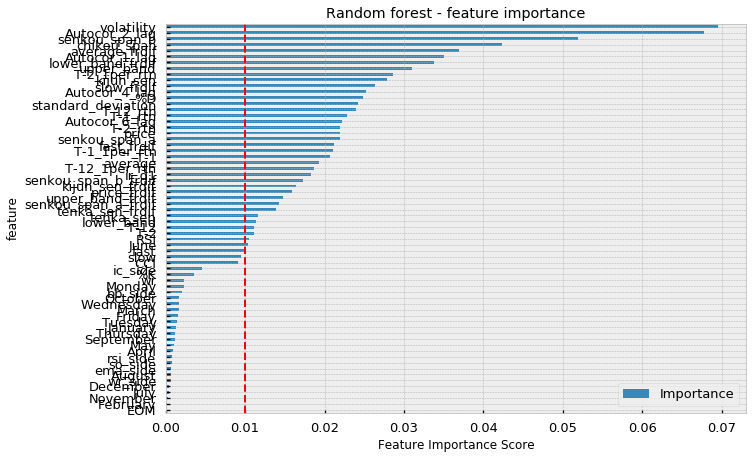

In [12]:
feat_imp = pd.DataFrame({'Importance':rfc.feature_importances_})    
feat_imp['feature'] = X_train[cols].columns
#feat_imp.sort_values(by='Importance', ascending=False, inplace=True)

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp[feat_imp.Importance>0].plot.barh(title='Random forest - feature importance')
plt.xlabel('Feature Importance Score')
plt.axvline(0.01, color='r', ls='--')
plt.show()

We can select features that Random Forest assumes to be important

In [13]:
top_feat = feat_imp[feat_imp.Importance>0.01].index
top_feat

Index(['June', 'RSI', 'T-2', 'T-12', 'lower_band', 'tenka_sen',
       'tenka_sen_frdif', 'senkou_span_a_frdif', 'upper_band_frdif',
       'price_frdif', 'kijun_sen_frdif', 'senkou_span_b_frdif', 'ir_d1',
       'T-12_1per_rtn', 'average', 'T-1', 'T-1_1per_rtn', 'fast_frdif',
       'senkou_span_a', 'price', 'T-2_rtn', 'Autocor_6_lag', 'T-1_rtn',
       'T-12_rtn', 'standard_deviation', '%D', 'Autocor_4_lag', 'slow_frdif',
       'kijun_sen', 'T-2_1per_rtn', 'upper_band', 'lower_band_frdif',
       'Autocor_1_lag', 'average_frdif', 'chikou_span', 'senkou_span_b',
       'Autocor_2_lag', 'volatility'],
      dtype='object', name='feature')

In [14]:
features = {'all_feature_cols':all_feature_cols, 
            'ex_frdiff_cols':ex_frdiff_cols,
            'frdiff_cols':frdiff_cols, 
            'top_feat_RF':top_feat
           }

models = {'LightGBM':LGBMClassifier(random_state = RANDOM_STATE), 
          'XGBoost':XGBClassifier(seed = RANDOM_STATE), 
         'Tuned RF':rfc,
         'RF':RandomForestClassifier(random_state=RANDOM_STATE),
          'ExtraTrees':ExtraTreesClassifier(random_state=RANDOM_STATE),
         'AdaBoost': AdaBoostClassifier(n_estimators=1000, random_state=RANDOM_STATE),
         'Scaler->PCA4->RF':make_pipeline(StandardScaler(),PCA(n_components=4),RandomForestClassifier(random_state=RANDOM_STATE)),
         'Scaler->PCA4->LogRegr': make_pipeline(StandardScaler(), PCA(n_components=4), LogisticRegression(max_iter=1000, tol=0.1)),
         'Scaler->SVM': make_pipeline(StandardScaler(), svm.SVC(kernel='rbf', random_state=RANDOM_STATE)),
         'Scaler->PCA4->SVM': make_pipeline(StandardScaler(), PCA(n_components=4), svm.SVC(kernel='rbf', random_state=RANDOM_STATE)),
         'Scaler->PCA20->SVM': make_pipeline(StandardScaler(), PCA(n_components=20), svm.SVC(kernel='rbf', random_state=RANDOM_STATE)),
         'Scaler->PCA6->Naive Bayes':make_pipeline(StandardScaler(), PCA(n_components=6), GaussianNB()),
          'Scaler->Naive Bayes':make_pipeline(StandardScaler(), GaussianNB())
         }                   

score = pd.DataFrame(np.nan, index=features.keys(), columns=models.keys())
score_stds = pd.DataFrame(np.nan, index=features.keys(), columns=models.keys())
rtns =  pd.DataFrame(np.nan, index=features.keys(), columns=models.keys())
sharp =  pd.DataFrame(np.nan, index=features.keys(), columns=models.keys())
n_splits = 5

Calculating accuracy scores

In [15]:
cv = KFold(n_splits=n_splits, shuffle=False)

for n,cols in features.items():
    #print('\n'+n)
    for m,c in models.items():
        n_scores = cross_val_score(c, X_train[cols], Y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
        score.loc[n,m] = np.mean(n_scores)
        score_stds.loc[n,m] = np.std(n_scores)

Calculating cross-validated returns and sharp ratios.
Please note that these are arithmetically linked returns (for simplicity).

In [16]:
for n,cols in features.items():
    for m,c in models.items():
        r, sh = cv_with_custom_score(c, X_train[cols], Y_train, target_rtns_train, n_folds=n_splits)
        rtns.loc[n,m] = r
        sharp.loc[n,m] = sh

## Accuracy map of these algorythms

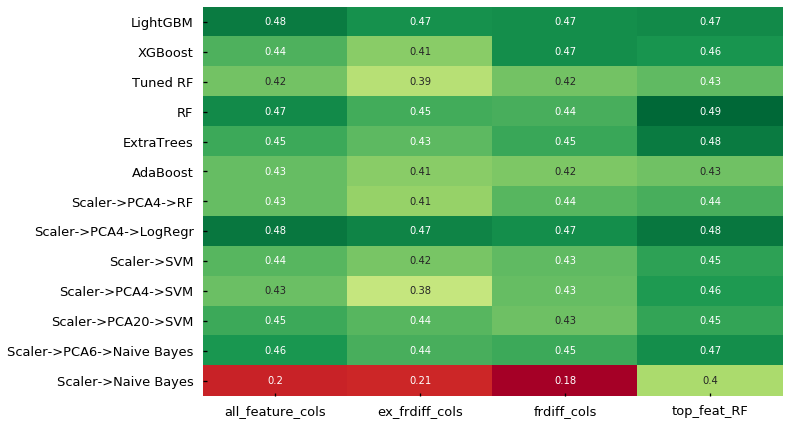

In [18]:
sns.heatmap(score.T,annot=True, cbar=False, cmap="RdYlGn")

Naive Bayes without PCA is showing the worst accuracy score and should not be used.

## Standard deviation of accuracy of these algorythms

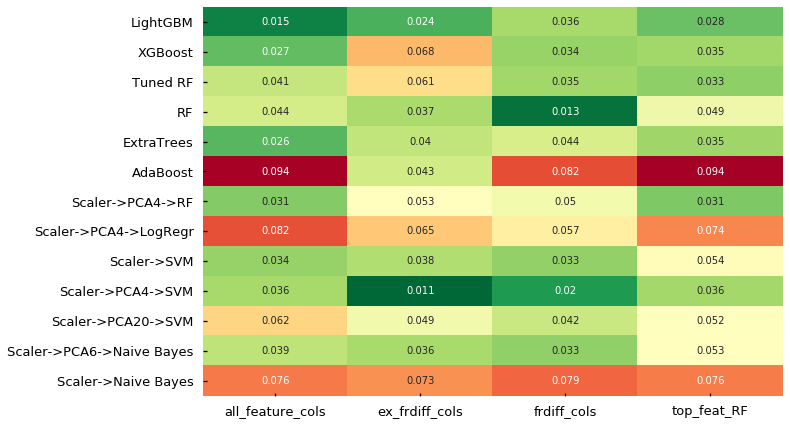

In [19]:
sns.heatmap(score_stds.T,annot=True, cbar=False, cmap="RdYlGn_r")

Algotythms trained on fractionally differentiated features show the lowest standard deviation of accuracy score.

___________________________________________
To check the performance of modells we will use bot validation and test results to make sure that the result is consistent.

## Cross-validated returns of the algorythms on the trainig set

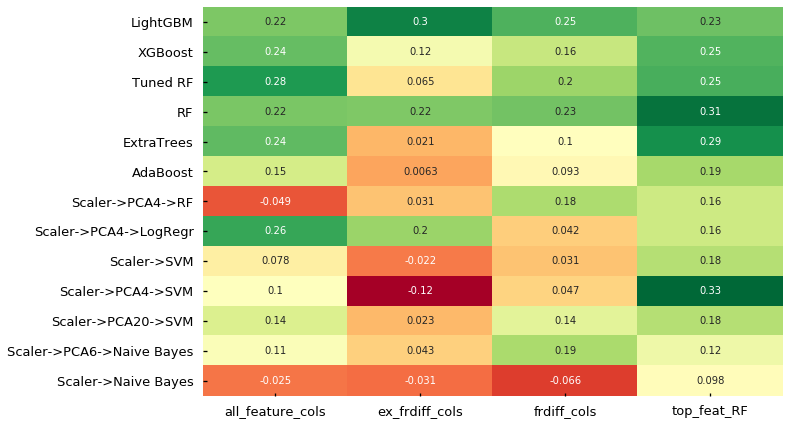

In [20]:
sns.heatmap(rtns.T,annot=True, cbar=False, cmap="RdYlGn")

Performance of SVM and Bayes is not good when we use features other than top features.

## Cross-validated volatility of returns of the algorythms on the traning set

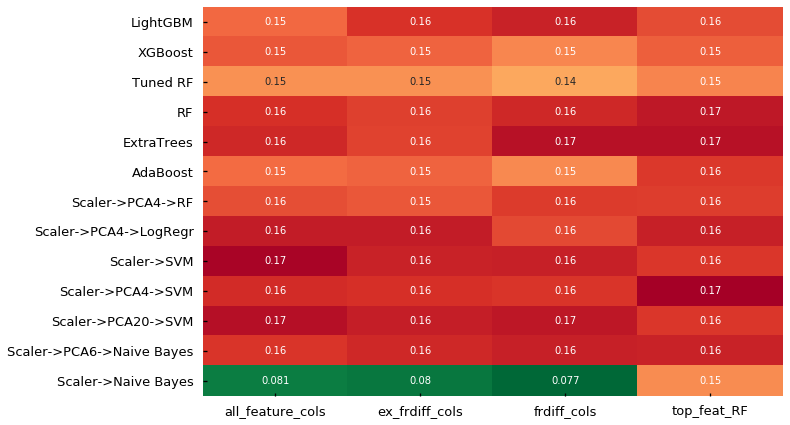

In [21]:
sns.heatmap((rtns/sharp).T,annot=True, cbar=False, cmap="RdYlGn_r")

## Sharp ratio - training set

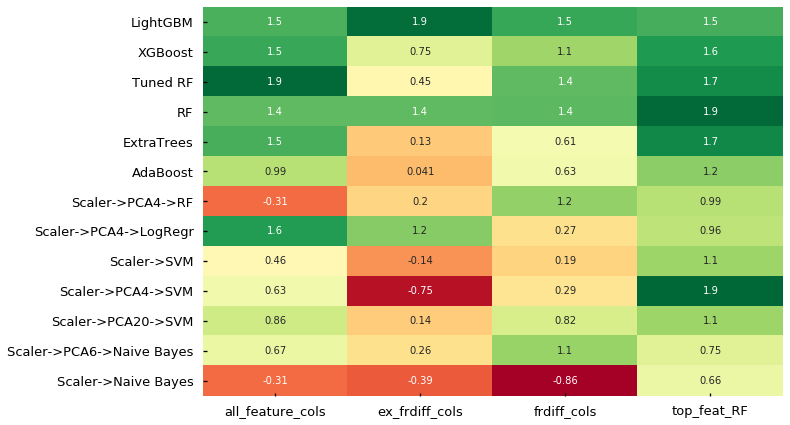

In [22]:
sns.heatmap(sharp.T,annot=True, cbar=False, cmap="RdYlGn")

### Running the same for the validation set
to make sure that the result holds

In [23]:
rtns_valid =  pd.DataFrame(np.nan, index=features.keys(), columns=models.keys())
sharp_valid =  pd.DataFrame(np.nan, index=features.keys(), columns=models.keys())

for n,cols in features.items():
    #print('\n'+n)
    for m,c in models.items():
        rtn = c.fit(X_train[cols],Y_train).predict(X_valid[cols]) * target_rtns_valid
        days = np.busday_count(X_valid.index.min().date(),X_valid.index.max().date())
        rtns_valid.loc[n,m] = np.sum(rtn) * 252 /days
        vol = np.std(rtn.groupby(rtn.index.date).sum())*np.sqrt(252)
        sharp_valid.loc[n,m] = rtns_valid.loc[n,m] / vol

## Returns - validation set

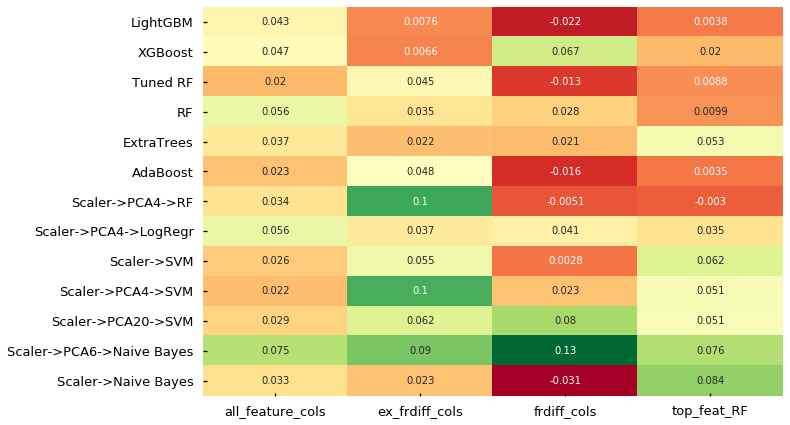

In [24]:
sns.heatmap(rtns_valid.T,annot=True, cbar=False, cmap="RdYlGn")

## Volatility - validation set

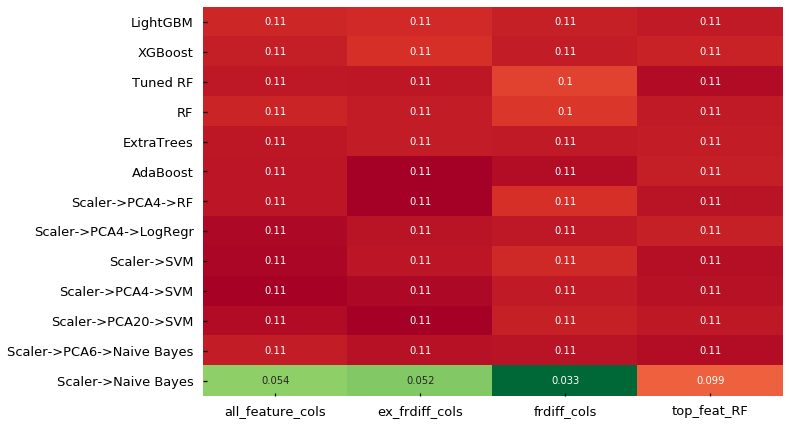

In [25]:
sns.heatmap((rtns_valid/sharp_valid).T,annot=True, cbar=False, cmap="RdYlGn_r")

## Sharp - validation set

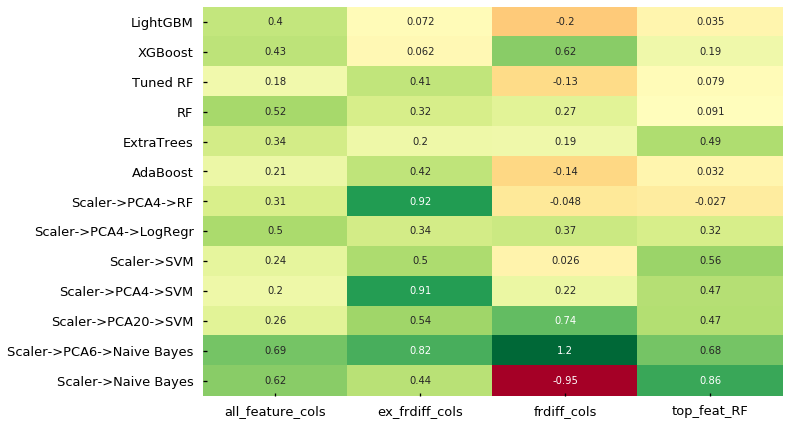

In [26]:
sns.heatmap(sharp_valid.T,annot=True, cbar=False, cmap="RdYlGn")

From the above we can see that it is hard to pick winners since the dispersion of results is high. It may be worth running the same for all currency pairs to understand what algorythms perform better that others on average. 

------
Below is a simple example of applying these algorythms on the validation data

In [27]:
import pyfolio as pf

In [28]:
def get_pyfolio_simple_tear_sheet(mdl,X_tr, Y_tr, X_tst, Y_tst, rtns_actual):
    mdl.fit(X_tr, Y_tr)
    predicted_labels = pd.Series(mdl.predict(X_tst), index = Y_tst.index)
    rtns = predicted_labels * rtns_actual
    pf.create_simple_tear_sheet(rtns)

Start date,2017-05-18
End date,2019-01-04
Total months,11
,Backtest
Annual return,12.146%
Cumulative returns,11.434%
Annual volatility,9.962%
Sharpe ratio,1.20
Calmar ratio,2.22
Stability,0.87
Max drawdown,-5.46%


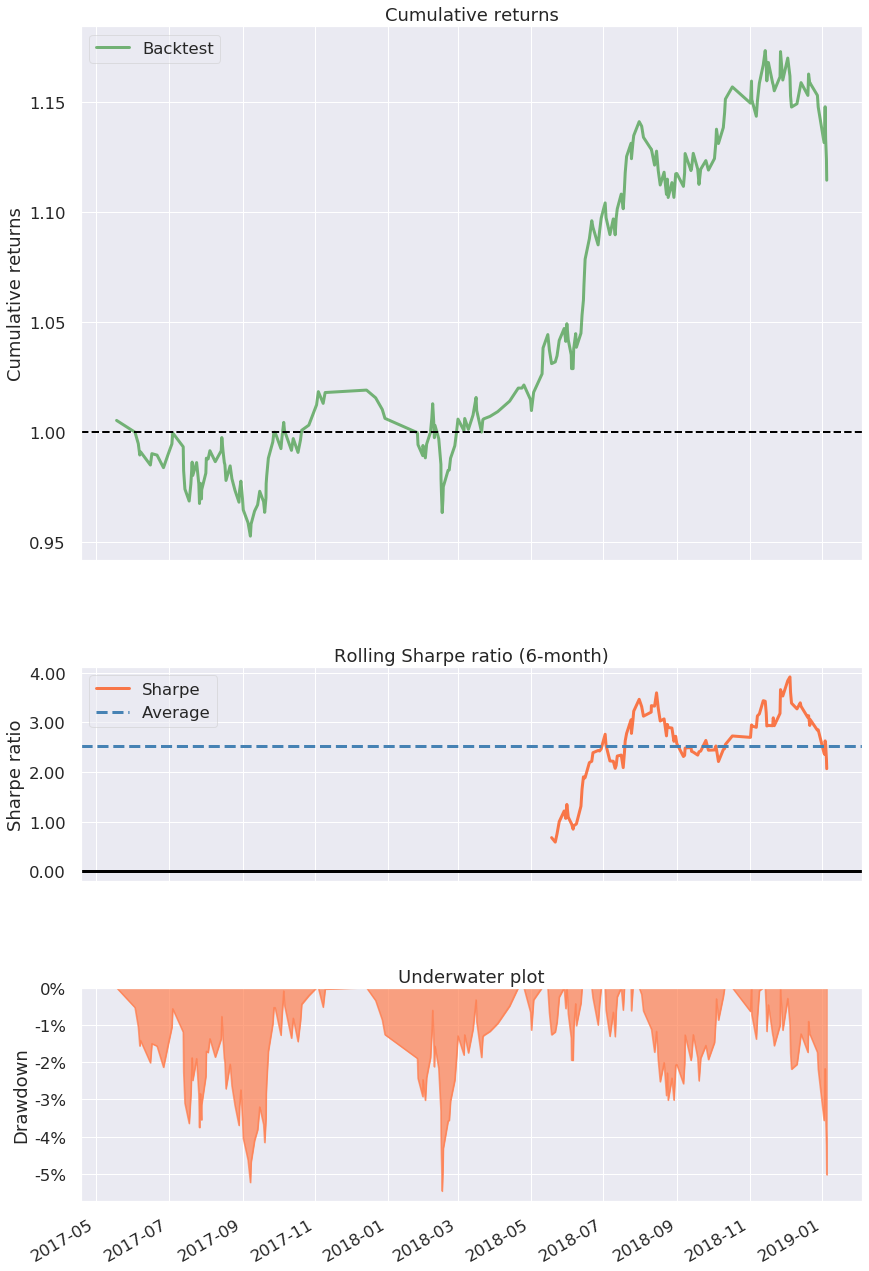

In [38]:
cols = features['frdiff_cols']
model = models['XGBoost']
validation = True
if validation:
    get_pyfolio_simple_tear_sheet(model,X_train[cols], Y_train, X_valid[cols], Y_valid, target_rtns_valid)
else:
    get_pyfolio_simple_tear_sheet(model,X_valid[cols], Y_valid, X_test[cols], Y_test, target_rtns_test)

Start date,2017-05-18
End date,2019-01-04
Total months,11
,Backtest
Annual return,11.1%
Cumulative returns,10.453%
Annual volatility,10.031%
Sharpe ratio,1.10
Calmar ratio,1.39
Stability,0.71
Max drawdown,-7.965%


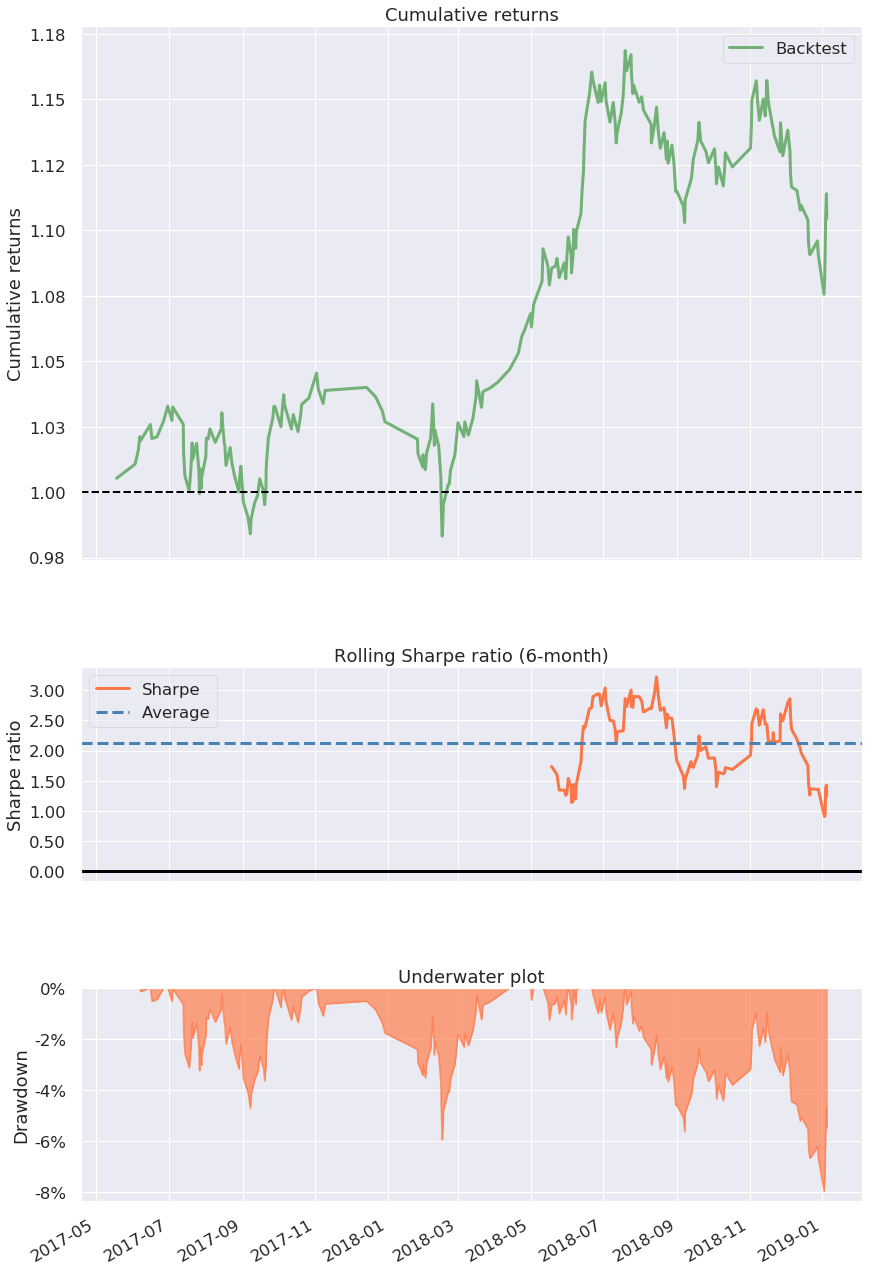

In [34]:
cols = features['top_feat_RF']
model = models['Scaler->SVM']
validation = True
if validation:
    get_pyfolio_simple_tear_sheet(model,X_train[cols], Y_train, X_valid[cols], Y_valid, target_rtns_valid)
else:
    get_pyfolio_simple_tear_sheet(model,X_valid[cols], Y_valid, X_test[cols], Y_test, target_rtns_test)

### Conclusion
We need to do thorough testing of all models for selected currency pairs to choose the right model/ensemple. As a criteria it may be worth to use Sharp Ratio as it incorporates both return and volatility.
Part of the code from this notebook will be moved into a wqu package for further use.